<H1> Machine Learning Application </H1>

<H3>Libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

<h3>Variables:

In [2]:
classification = 'binary'
#classification = 'selected'

#train_file = 'train-'
train_file = 'wind-train-'
#train_file = 'feature-train-'

project = 'athena-i'
metric_file = 'metrics.csv'

dataset_path = "%s/%s/dataset/%s/" % (os.getenv('HOME'), project, classification)
result_path = "%s/%s/results/%s/" % (os.getenv('HOME'), project, classification)

if classification == 'binary':
    classes = ["normal", "stress"]
    labels = [1, 2]
else:
    classes = ["pre-stress", "stress", "post-stress"]
    labels = [1, 2, 3]

<h3>Methods:

In [3]:
def load_dataset(path):
    x_train = pd.read_csv('%s%sx' % (path, train_file), delimiter=';')
    x_train = x_train.drop(columns=['PARTICIPANT','CLINICAL'])
    x_train = x_train.to_numpy()

    y_train = pd.read_csv('%s%sy' % (path, train_file), delimiter=';')
    y_train = y_train.to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.33, random_state = 1)

    return(x_train, y_train, x_test, y_test)

In [4]:
def get_metrics(y_test, y_predicted):
    data_metrics = []
    accuracy = metrics.accuracy_score(y_test, y_predicted)
    f1 = metrics.f1_score(y_test, y_predicted, average='weighted', pos_label=1)
    precision = metrics.precision_score(y_test, y_predicted, average='weighted', pos_label=1)
    recall = metrics.recall_score(y_test, y_predicted, average='weighted', pos_label=1)
    data_metrics.append(accuracy)
    data_metrics.append(f1)
    data_metrics.append(precision)
    data_metrics.append(recall)
    print("Accuracy: %.5f\tPrecision: %.5f\n" % (accuracy, precision))
    print("Recall: %.5f\t\tF1: %.5f" % (recall, f1))
    
    return data_metrics

In [5]:
def show_confusion_matrix(y_test, y_predicted, classifier, labels):   
    cm = confusion_matrix(y_test, y_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cmn*100, 
                cmap='coolwarm',
                linecolor='white',
                linewidths=0.8,
                annot=True, 
                fmt='.3f', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('%s%s-confusion-matrix-percent.png' % (result_path, classifier))
    
    
    
    cm = confusion_matrix(y_test, y_predicted, labels)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm,
                cmap='Greys',
                annot=True, 
                fmt='.0f', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('%s%s-confusion-matrix.png' % (result_path, classifier))

In [6]:
def class_accuracy(y_test, y_predicted, classifier): 
    cm = confusion_matrix(y_test, y_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    f = open('%s%s-accuracy-per-class.txt' % (result_path, classifier), 'a')
    f.write("Class Accuracy\n")
    plt.show(block=False)
    index_acurácia = (cmn.diagonal())*100
    print('\nClass Accuracy')
    for i in range(len(index_acurácia)): 
        print('Class %s: %.2f' % (classes[i], index_acurácia[i]), '%')
        f.write(str('%.2f' %(index_acurácia[i])))
        f.write("\n")
    f.write("\n")
    f.close()

In [7]:
def weighted_accuracy(y_test, y_predicted, classifier): 
    valor = 0;
    cm = confusion_matrix(y_test, y_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Imprime a acurácia de cada classe
    f = open('%s%s-weighted-accuracy.txt' % (result_path, classifier), 'a')
    plt.show(block=False)
    index_acurácia = (cmn.diagonal())*100
    for i in range(len(index_acurácia)): 
        valor = valor + index_acurácia[i];
    valor = valor/len(index_acurácia);
    print('\nWeighted accuracy: %.2f' %(valor), '%')
    f.write(str('%.2f' %(valor)))
    f.write("\n")
    f.close()

In [8]:
def final_accuracy(y_test, y_predicted, classifier):
    score = accuracy_score(y_test, y_predicted)
    print('\nGeneral Accuracy: %.2f' % (score*100),'%')
    f = open('%s%s-general-accuracy.txt' % (result_path, classifier), 'a')
    f.write("Final accuracy: ")
    f.write(str('%.2f' %(score*100)))
    f.write("\n")

<H3>Call Methods:</H3>

Load Data

In [9]:
x_train, y_train, x_test, y_test = load_dataset(dataset_path)

In [10]:
data_metrics = pd.DataFrame(index=['Accuracy','F1','Precision','Recall'])

<H3>Machine Learning Application:</H3>

Decision Tree Classifier

Accuracy: 0.99942	Precision: 0.99942

Recall: 0.99942		F1: 0.99942

General Accuracy: 99.94 %

Weighted accuracy: 99.94 %

Class Accuracy
Class normal: 99.93 %
Class stress: 99.95 %


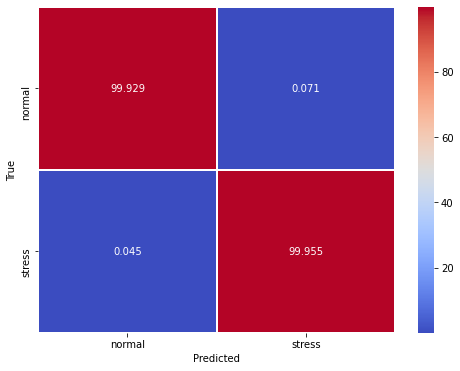

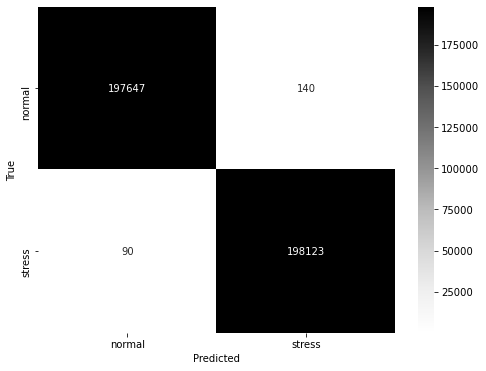

In [11]:
classifier = 'decision-tree-classifier'
model=DecisionTreeClassifier(random_state=np.random)
model.fit(x_train,y_train)
y_predicted=model.predict(x_test)
data_metrics[classifier] = get_metrics(y_test, y_predicted)
final_accuracy(y_test, y_predicted, classifier)
weighted_accuracy(y_test, y_predicted, classifier)
class_accuracy(y_test, y_predicted, classifier)
show_confusion_matrix(y_test, y_predicted, classifier, labels)

KNN (KNeighbors Classifier)

Accuracy: 0.99678	Precision: 0.99678

Recall: 0.99678		F1: 0.99678

General Accuracy: 99.68 %

Weighted accuracy: 99.68 %

Class Accuracy
Class normal: 99.66 %
Class stress: 99.69 %


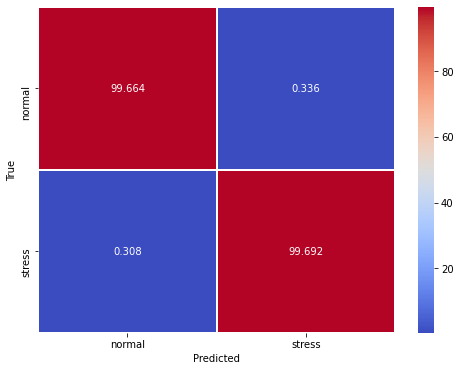

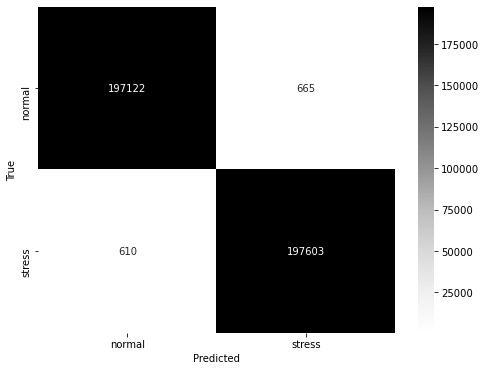

In [12]:
classifier = 'kneighbors-classifier'
model=KNeighborsClassifier(n_neighbors=3)
model.fit(x_train,y_train)
y_predicted=model.predict (x_test)
data_metrics[classifier] = get_metrics(y_test, y_predicted)
final_accuracy(y_test, y_predicted, classifier)
weighted_accuracy(y_test, y_predicted, classifier)
class_accuracy(y_test, y_predicted, classifier)
show_confusion_matrix(y_test, y_predicted, classifier, labels)

Random Forest Classifier

Accuracy: 0.99955	Precision: 0.99955

Recall: 0.99955		F1: 0.99955

General Accuracy: 99.96 %

Weighted accuracy: 99.96 %

Class Accuracy
Class normal: 99.94 %
Class stress: 99.97 %


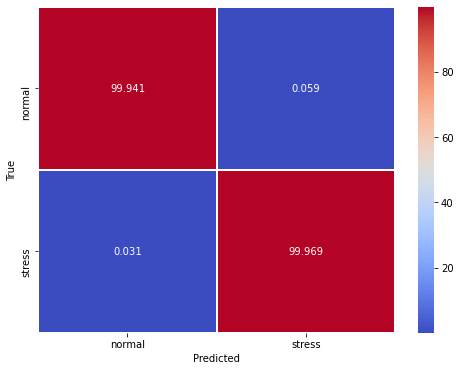

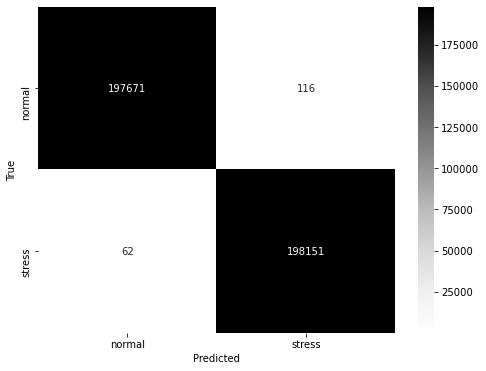

In [13]:
classifier = 'random-forest-classifier'
model=RandomForestClassifier(n_estimators=100, criterion='entropy',
                             max_depth=None, n_jobs=-1, bootstrap=True,
                             random_state=np.random)
model.fit(x_train,y_train)
y_predicted=model.predict(x_test)
data_metrics[classifier] = get_metrics(y_test, y_predicted)
final_accuracy(y_test, y_predicted, classifier)
weighted_accuracy(y_test, y_predicted, classifier)
class_accuracy(y_test, y_predicted, classifier)
show_confusion_matrix(y_test, y_predicted, classifier, labels)

In [14]:
data_metrics.to_csv('%s%s' % (result_path, metric_file), index=True, header=True, sep=';', encoding='utf-8')